---
title: 00 - Figures
author: [Martin Proks, Nazmus Salehin]
date: 31-08-2023
---

- **Figure 1**
    - [x] FA plot 
    - [x] PAGA
    - [x] Pseudotime
    - [x] Celltype/Stage density
    - [x] CellRank
    - [x] Markers (literature)
    - [x] DEGs
    - [x] Leiden clusters
    - [x] Celltype compositions
    - [x] scib (yosef lab)
- **Fig 2**
    - [ ] Schematics of different classifications
    - [ ] SHAP values
- **Fig 3**
    - [x] Query datasets (in vitro)
    - [x] Classification predictions
    - [x] AUROC curves/Entropy

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import scvi
import scanpy as sc
import cellrank as cr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


import scvelo as scv
scv.set_figure_params('scvelo')

import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [5]:
from scvi.model import SCANVI

In [6]:
%run ../scripts/helpers.py

In [7]:
plt.rcParams['svg.fonttype'] = 'none'

sc.settings.figdir = '../figures/mouse/'
sc.set_figure_params(dpi=120, dpi_save = 300, format='svg', transparent=True, figsize=(6,5))

scv.settings.figdir = '../figures/mouse/'
scv.set_figure_params(dpi=120, dpi_save = 300, format='svg', transparent=True, figsize=(6,5))

In [8]:
mouse = sc.read("../results/03_mouse.processed.h5ad")
mouse.obs.stage = mouse.obs.stage.astype('category').cat.reorder_categories(['Zygote', '2C', '4C', '8C', '16C', 'ICM', 'TE', 'EPI', 'PrE'])

## Oocyte counts

- Borensztein contains 32 and 64 cell cells (also contains oocytes, how many?)
- Deng # of occytes
- Xu et al., oocyte + pronuclear

In [ ]:
n_oocytes = 0

In [ ]:
borenszrtein_metadata = pd.read_table("https://ftp.ncbi.nlm.nih.gov/geo/series/GSE80nnn/GSE80810/matrix/GSE80810_series_matrix.txt.gz",
                                      skiprows=31, index_col=0).T
borenszrtein_metadata['SRX'] = borenszrtein_metadata[['!Sample_relation']].iloc[:, :2].agg(' '.join, axis=1).str.extract(r'(SRX[0-9]{6})')
borenszrtein_metadata['ct'] = borenszrtein_metadata['!Sample_characteristics_ch1'].iloc[:, 1].values
borenszrtein_metadata = borenszrtein_metadata.reset_index()

In [ ]:
deng_oocytes = ['GSM1112766', 'GSM1112767', 'GSM1112768', 'GSM1112769']

In [ ]:
xue_metadata = pd.read_table("https://ftp.ncbi.nlm.nih.gov/geo/series/GSE44nnn/GSE44183/matrix/GSE44183-GPL13112_series_matrix.txt.gz",
                               skiprows=35, index_col=0).T
xue_metadata['SRX'] = xue_metadata[['!Sample_relation']].agg(' '.join, axis=1).str.extract(r'(SRX[0-9]{6})')
xue_metadata['ct'] = xue_metadata['!Sample_source_name_ch1']
xue_metadata = xue_metadata.reset_index()

In [ ]:
n_oocytes += borenszrtein_metadata[borenszrtein_metadata.ct.str.contains('Oocyte')].shape[0]
n_oocytes += len(deng_oocytes)
n_oocytes += xue_metadata[xue_metadata.ct == 'oocyte'].shape[0]

In [ ]:
print(f'Number of Oocytes in from experiments: {n_oocytes}')

In [ ]:
mouse.obs.ct.value_counts()

## Figures

In [9]:
# lineage_colors = {
#     'Zygote': '#a24f99',
#     '2C': '#55ae6c',
#     '4C': '#93b43e',
#     '8C': '#ba4a50',
#     '16C': '#657cbd',
#     'ICM': '#ffcb5d',
#     'TE': '#5a94ce',
#     'EPI': '#d22a45',
#     'PrE': '#a377b4'
# }
lineage_colors = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'ICM': '#F6C445',
    'TE': '#5a94ce',
    'EPI': '#B46F9C',
    'PrE': '#D05B61'
}

# ct_colors = {
#     'Zygote': '#7985A5',
#     '2C': '#B3C81E',
#     '4C': '#67BB30',
#     '8C': '#028A46',
#     '16C': '#657cbd',
#     'E3.25-ICM': '#e5b653',
#     'E3.25-TE': '#5185b9',
#     'E3.5-ICM': '#cca24a',
#     'E3.5-TE': '#406a94',
#     'E3.5-EPI': '#bd253e',
#     'E3.5-PrE': '#926ba2',
#     'E3.75-ICM': '#F6C445',
#     'E4.5-TE': '#5a94ce',
#     'E4.5-EPI': '#B46F9C',
#     'E4.5-PrE': '#D05B61'
# }
ct_colors = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'E3.25-ICM': '#fadc8f',
    'E3.25-TE': '#5185b9',
    'E3.5-ICM': '#f8d06a',
    'E3.5-TE': '#7ba9d8',
    'E3.5-EPI': '#c38cb0',
    'E3.5-PrE': '#d97c81',
    'E3.75-ICM': '#F6C445',
    'E4.5-TE': '#5a94ce',
    'E4.5-EPI': '#B46F9C',
    'E4.5-PrE': '#D05B61'
}

extras = { 'add_outline': True, 'outline_width': (0.16, 0.02) }

mouse.uns['stage_colors'] = list(lineage_colors.values())
mouse.uns['ct_colors'] = list(ct_colors.values())

In [ ]:
sc.pp.neighbors(mouse, use_rep='X_scVI')
sc.tl.diffmap(mouse)
sc.tl.paga(mouse, groups='ct')
sc.tl.draw_graph(mouse, init_pos='paga', n_jobs=10)

In [ ]:
sc.pl.draw_graph(mouse, color=['stage', 'timepoint', 'ct'], frameon=True, wspace=0.2)

## DR

In [ ]:
sc.pl.draw_graph(mouse, color=['stage', 'leiden', 'ct'], frameon=True, wspace=0.2, save="_dr_.svg")

In [ ]:
sc.pl.tsne(mouse, color=['stage', 'leiden', 'ct'], frameon=True, wspace=0.2, save="_dr_.svg")

In [ ]:
sc.pl.umap(mouse, color=['stage', 'leiden', 'ct'], frameon=True, wspace=0.2, save="_dr_.svg")

### FA plot

In [ ]:
sc.pl.embedding(mouse, basis='X_draw_graph_fa', color=['stage'], title='', legend_loc=None,
                frameon=False, **extras, save="_stage.svg")

In [ ]:
sc.pl.embedding(mouse, basis='X_draw_graph_fa', color='leiden', title='', legend_loc='on data', legend_fontoutline=2,
                frameon=False, **extras, save="_leiden.svg")

In [ ]:
sc.pl.embedding(mouse, basis='X_draw_graph_fa', color='leiden', title='', frameon=False, **extras, save="_leiden_2.svg")

In [ ]:
mouse.obs['t_scaled'] = MinMaxScaler().fit_transform(mouse.obs['t'].values.reshape(-1, 1)).flatten()

sc.pl.embedding(mouse, basis='X_draw_graph_fa', color=['t_scaled', 'dpt_pseudotime'], title=['scFates pseudotime', 'dpt_pseudotime'], 
                legend_loc=None, colorbar_loc='right', frameon=True, cmap='viridis', **extras, save="_pseudotimes.svg")

In [ ]:
sc.tl.embedding_density(mouse, basis='draw_graph_fa', groupby='stage')
sc.pl.embedding_density(mouse, basis='draw_graph_fa', key='draw_graph_fa_density_stage', ncols=3, save='.svg')

In [ ]:
sc.tl.embedding_density(mouse, basis='draw_graph_fa', groupby='ct')
sc.pl.embedding_density(mouse, basis='draw_graph_fa', key='draw_graph_fa_density_ct', ncols=3, save='.svg')

### PAGA

In [ ]:
scv.pl.paga(mouse, basis='draw_graph_fa', title="", **extras, frameon=True, save="ct.svg")

### scGEN

In [ ]:
mouse_scgen = sc.read("../results/02_mouse_integration/scgen/adata.h5ad")

sc.pp.neighbors(mouse_scgen, use_rep='X_scgen')
sc.tl.diffmap(mouse_scgen)
sc.tl.paga(mouse_scgen, groups='ct')
sc.pl.paga(mouse_scgen)
sc.tl.draw_graph(mouse_scgen, init_pos='paga', n_jobs=10)

In [ ]:
mouse_scgen.uns['stage_colors'] = list(lineage_colors.values())[1:] + [lineage_colors['Zygote']]
sc.pl.embedding(mouse_scgen, basis='X_draw_graph_fa', color=['stage'], title='scGen',
                **extras, save="_scgen_stage.svg")

## Trajectory segmentation

In [ ]:
import scFates as scf

In [ ]:
# with plt.rc_context({"figure.figsize": (6, 6)}):
fig, ax = plt.subplots(1, 3, figsize=[18, 5])
scf.pl.dendrogram(mouse,color="seg", show=False, ax=ax[0])
scf.pl.dendrogram(mouse,color="ct", legend_loc="on data", color_milestones=True, legend_fontoutline=True, show=False, ax=ax[1])
sc.pl.embedding(mouse, basis='X_draw_graph_fa', color='seg', ax=ax[2])
fig.tight_layout()
fig.savefig("../figures/mouse/scfates.svg")

## CellRank

In [ ]:
from cellrank.kernels import PseudotimeKernel

pk = PseudotimeKernel(mouse, time_key="t")
pk.compute_transition_matrix()
g = cr.estimators.GPCCA(pk)
g.fit(cluster_key="stage", n_states=[4, 12])
g.predict_terminal_states(n_states=3)
g.predict_initial_states(allow_overlap=True)
g.compute_fate_probabilities()

In [ ]:
mouse.uns['clusters_gradients_colors'] = [lineage_colors['Zygote'], lineage_colors['TE'], lineage_colors['PrE'], lineage_colors['EPI']]
g.plot_fate_probabilities(same_plot=True, basis='X_draw_graph_fa', **extras, legend_loc=False, save="mouse_terminal_stages.svg")

In [ ]:
g.plot_fate_probabilities(same_plot=False, basis='X_draw_graph_fa', legend_loc=False, **extras, save="mouse_terminal_stages_all.svg")

## Stats: Cell compositions

In [ ]:
experiment_stats = mouse.obs.groupby(['experiment', 'stage']).apply(len).unstack().fillna(0).iloc[::-1]
experiment_stats.plot(kind='barh', stacked=True, color=lineage_colors)

for y, x in enumerate(experiment_stats.sum(axis=1).astype(int)):
    plt.annotate(str(x), xy=(x + 10, y), va='center')

plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().legend(frameon=False)
_ = plt.ylabel('Publications')
_ = plt.xlabel('Number of cells')
plt.savefig("../figures/mouse/stats_publications.svg")

In [ ]:
lineage_stats = mouse.obs.groupby('stage').apply(len).iloc[::-1]
lineage_stats.plot(kind='barh', color=list(lineage_colors.values()))

for y, x in enumerate(lineage_stats.astype(int)):
    plt.annotate(str(x), xy=(x + 10, y), va='center')

plt.gca().spines[['right', 'top']].set_visible(False)
_ = plt.ylabel('Lineage')
_ = plt.xlabel('Number of cells')
plt.savefig("../figures/mouse/stats_stages.svg")

In [ ]:
leiden_stats = sc.metrics.confusion_matrix('stage', 'leiden', data=mouse.obs) * 100
leiden_stats.plot(kind='barh', stacked=True)

plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().legend(title='Clusters', bbox_to_anchor=(0.99, 1.02), loc='upper left', frameon=False)
_ = plt.ylabel('Lineages')
_ = plt.xlabel('Cluster %')
plt.savefig("../figures/mouse/stats_cluster_vs_lineages.svg")

In [ ]:
leiden_stats = sc.metrics.confusion_matrix('leiden', 'stage', data=mouse.obs) * 100
leiden_stats.plot(kind='barh', stacked=True, color=lineage_colors)

plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().legend(title='Clusters', bbox_to_anchor=(0.99, 1.02), loc='upper left', frameon=False)
_ = plt.ylabel('Lineages')
_ = plt.xlabel('Cluster %')
plt.savefig("../figures/mouse/stats_cluster_vs_lineages.svg")

In [ ]:
sc.pl.embedding(mouse, basis='X_draw_graph_fa', color=['stage', 'leiden'], title='', frameon=False)

In [ ]:
leiden_stats = sc.metrics.confusion_matrix('leiden', 'stage', data=mouse.obs) * 100
leiden_stats_order = ['13', '12', '7', '1', '11', '6', '0', '14', '2', '5', '4', '9', '8', '3', '10']
leiden_stats.loc[leiden_stats_order[::-1]].plot(kind='barh', stacked=True, color=lineage_colors)

plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().legend(title='Clusters', bbox_to_anchor=(0.99, 1.02), loc='upper left', frameon=False)
_ = plt.ylabel('Lineages')
_ = plt.xlabel('Cluster %')
plt.savefig("../figures/mouse/stats_cluster_vs_lineages.svg")

In [ ]:
technology_stats = mouse.obs.groupby('technology').apply(len).sort_values()
technology_stats.plot(kind='barh', color='grey')

for y, x in enumerate(technology_stats.astype(int)):
    plt.annotate(str(x), xy=(x + 10, y), va='center')

plt.gca().spines[['right', 'top']].set_visible(False)
_ = plt.ylabel('Technology')
_ = plt.xlabel('Number of cells')
plt.savefig("../figures/mouse/stats_technology.svg")

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=[20, 4])

# Plot #1
experiment_stats = experiment_stats.loc[experiment_stats.sum(axis=1).sort_values().index.tolist()]
experiment_stats.plot(kind='barh', stacked=True, color=lineage_colors, ax=ax[0])
for y, x in enumerate(experiment_stats.sum(axis=1).astype(int)):
    ax[0].annotate(str(x), xy=(x + 10, y), va='center')
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].legend(frameon=False)
ax[0].set_ylabel('Publications')
ax[0].set_xlabel('Number of cells')

# Plot #2
lineage_stats = mouse.obs.groupby('stage').apply(len)
lineage_stats.plot(kind='barh', color=list(lineage_colors.values()), ax=ax[1])
for y, x in enumerate(lineage_stats.astype(int)):
    ax[1].annotate(str(x), xy=(x + 10, y), va='center')
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_ylabel('Lineage')
ax[1].set_xlabel('Number of cells')

# Plot #3
technology_stats = mouse.obs.groupby('technology').apply(len).sort_values()
technology_stats.plot(kind='barh', color='grey', ax=ax[2])
for y, x in enumerate(technology_stats.astype(int)):
    ax[2].annotate(str(x), xy=(x + 10, y), va='center')
ax[2].spines[['right', 'top']].set_visible(False)
ax[2].set_ylabel('Technology')
ax[2].set_xlabel('Number of cells')

# Plot #4
leiden_stats = sc.metrics.confusion_matrix('leiden', 'stage', data=mouse.obs) * 100
leiden_stats.plot(kind='barh', stacked=True, ax=ax[3])
ax[3].spines[['right', 'top']].set_visible(False)
ax[3].legend(title='Clusters', bbox_to_anchor=(0.99, 1.02), loc='upper left', frameon=False)
ax[3].set_ylabel('Lineages')
ax[3].set_xlabel('Cluster %')

fig.tight_layout(w_pad=1)
fig.savefig("../figures/mouse/stats_all.svg")

## Markers

In [ ]:
vae = scvi.model.SCVI.load("../results/02_mouse_integration/scvi/", mouse)

In [ ]:
mouse.layers['scVI_denoised'] = vae.get_normalized_expression(n_samples=10, return_mean=True)

#### Literature

In [ ]:
lineage_markers = pd.read_excel("../data/external/mouse_lineage_markers.xlsx", sheet_name="Sheet1").fillna('')[lineage_colors.keys()]
display(lineage_markers)

lineage_markers = { 
    lineage : mouse.var_names.intersection([str.lower(g) for g in genes])
    for lineage, genes in lineage_markers.T.iterrows()
}

In [ ]:
lineage_markers

In [ ]:
sc.pl.dotplot(mouse, lineage_markers, groupby='stage', standard_scale='var')
sc.pl.dotplot(mouse, lineage_markers, groupby='stage', standard_scale='var', layer='scVI_denoised')

In [ ]:
sc.pl.matrixplot(mouse, lineage_markers, groupby='stage', standard_scale='var', cmap='viridis')
sc.pl.matrixplot(mouse, lineage_markers, groupby='stage', standard_scale='var', cmap='viridis', layer='scVI_denoised')

In [ ]:
pub_markers = {
    'Zygote': ['zswim3', 'padi6'],
    '2C': ['zfp352', 'zscan4d'],
    '4C': ['sox21'],
    '8C': ['prdm14', 'pou5f1'],
    '16C': ['tfap2c', 'gata3'],
    'ICM': ['tfcp2l1', 'pou5f1'],
    'TE': ['eomes', 'cdx2'],
    'EPI': ['sox2', 'nanog'],
    'PrE': ['gata6', 'pdgfra']
}
ax = sc.pl.dotplot(mouse, sum(pub_markers.values(), []), groupby='stage', standard_scale='var', cmap='GnBu', figsize=[12, 3.5], show=False)
_ = ax['mainplot_ax'].set_xticklabels(sum(pub_markers.values(), []), rotation = 45, ha="right", rotation_mode="anchor")
plt.savefig("../figures/mouse/dotplot_pub_markers.svg")

## SCVI DGEs

In [ ]:
m_lineage = vae.differential_expression(groupby="stage")
m_lineage_filt = filter_markers(m_lineage, n_genes=10)

display(pd.DataFrame.from_dict(m_lineage_filt, orient='index').transpose())

sc.pl.dotplot(mouse, m_lineage_filt, groupby='stage', dendrogram=False, standard_scale='var')
sc.pl.matrixplot(mouse, m_lineage_filt, groupby='stage', dendrogram=False, standard_scale='var')

## Classifiers

In [42]:
import scgen
import squarify
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import xgboost as xgb


from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

LABELS = ['scANVI', 'scANVI [ns=15]', 'XGBoost [scVI]', 'XGBoost [scANVI]', 'XGBoost [scGEN]']

In [43]:
mouse.obs.ct.value_counts()

E3.5-ICM     459
E3.5-PrE     254
E4.5-PrE     207
16C          198
E3.5-EPI     175
8C           115
4C           114
E4.5-EPI     108
E3.5-TE      107
2C            86
E3.75-ICM     48
E3.25-TE      47
E3.25-ICM     40
E4.5-TE       28
Zygote        18
Name: ct, dtype: int64

In [44]:
predictions = mouse.obs[['ct']].copy()
xg_clf = xgb.XGBClassifier()

lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi/")
predictions['scANVI'] = lvae.predict()

lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi_ns_15/")
predictions['scANVI_ns15'] = lvae.predict()

vae = scvi.model.SCVI.load("../results/02_mouse_integration/scvi/")
xg_clf.load_model("../results/02_mouse_integration/05_scVI_xgboost.json")
predictions['xg_scVI'] = predictions.ct.cat.categories[xg_clf.predict(vae.get_normalized_expression(return_mean=True, return_numpy=True))]

lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi/")
xg_clf.load_model("../results/02_mouse_integration/05_scANVI_xgboost.json")
predictions['xg_scANVI'] = predictions.ct.cat.categories[xg_clf.predict(lvae.get_normalized_expression(return_mean=True, return_numpy=True))]

mscgen = scgen.SCGEN.load("../results/02_mouse_integration/scgen/")
xg_clf.load_model("../results/02_mouse_integration/05_scGEN_xgboost.json")
predictions['xg_scGEN'] = predictions.ct.cat.categories[xg_clf.predict(mscgen.get_decoded_expression())]

INFO     File ../results/02_mouse_integration/scanvi/model.pt already downloaded                                   
INFO     File ../results/02_mouse_integration/scanvi_ns_15/model.pt already downloaded                             
INFO     File ../results/02_mouse_integration/scvi/model.pt already downloaded                                     
INFO     File ../results/02_mouse_integration/scanvi/model.pt already downloaded                                   
INFO     File ../results/02_mouse_integration/scgen/model.pt already downloaded                                    


In [45]:
mouse_accuracy = pd.DataFrame([
    [
        accuracy_score(predictions.ct.tolist(), predictions[clf].tolist()), 
        balanced_accuracy_score(predictions.ct.tolist(), predictions[clf].tolist()),
        f1_score(predictions.ct.tolist(), predictions[clf].tolist(), average="micro"),
        f1_score(predictions.ct.tolist(), predictions[clf].tolist(), average="macro")
    ] for clf in predictions.columns[1:]
], index=predictions.columns[1:], columns=['Accuracy', 'Bal. Accuracy', 'F1 (micro)', 'F1 (macro)'])

mouse_accuracy

Accuracy  Bal. Accuracy  F1 (micro)  F1 (macro)
scANVI       0.830339       0.649818    0.830339    0.634290
scANVI_ns15  0.793413       0.879503    0.793413    0.777624
xg_scVI      0.963074       0.975837    0.963074    0.976084
xg_scANVI    0.941617       0.960426    0.941617    0.963795
xg_scGEN     0.983034       0.984459    0.983034    0.986173

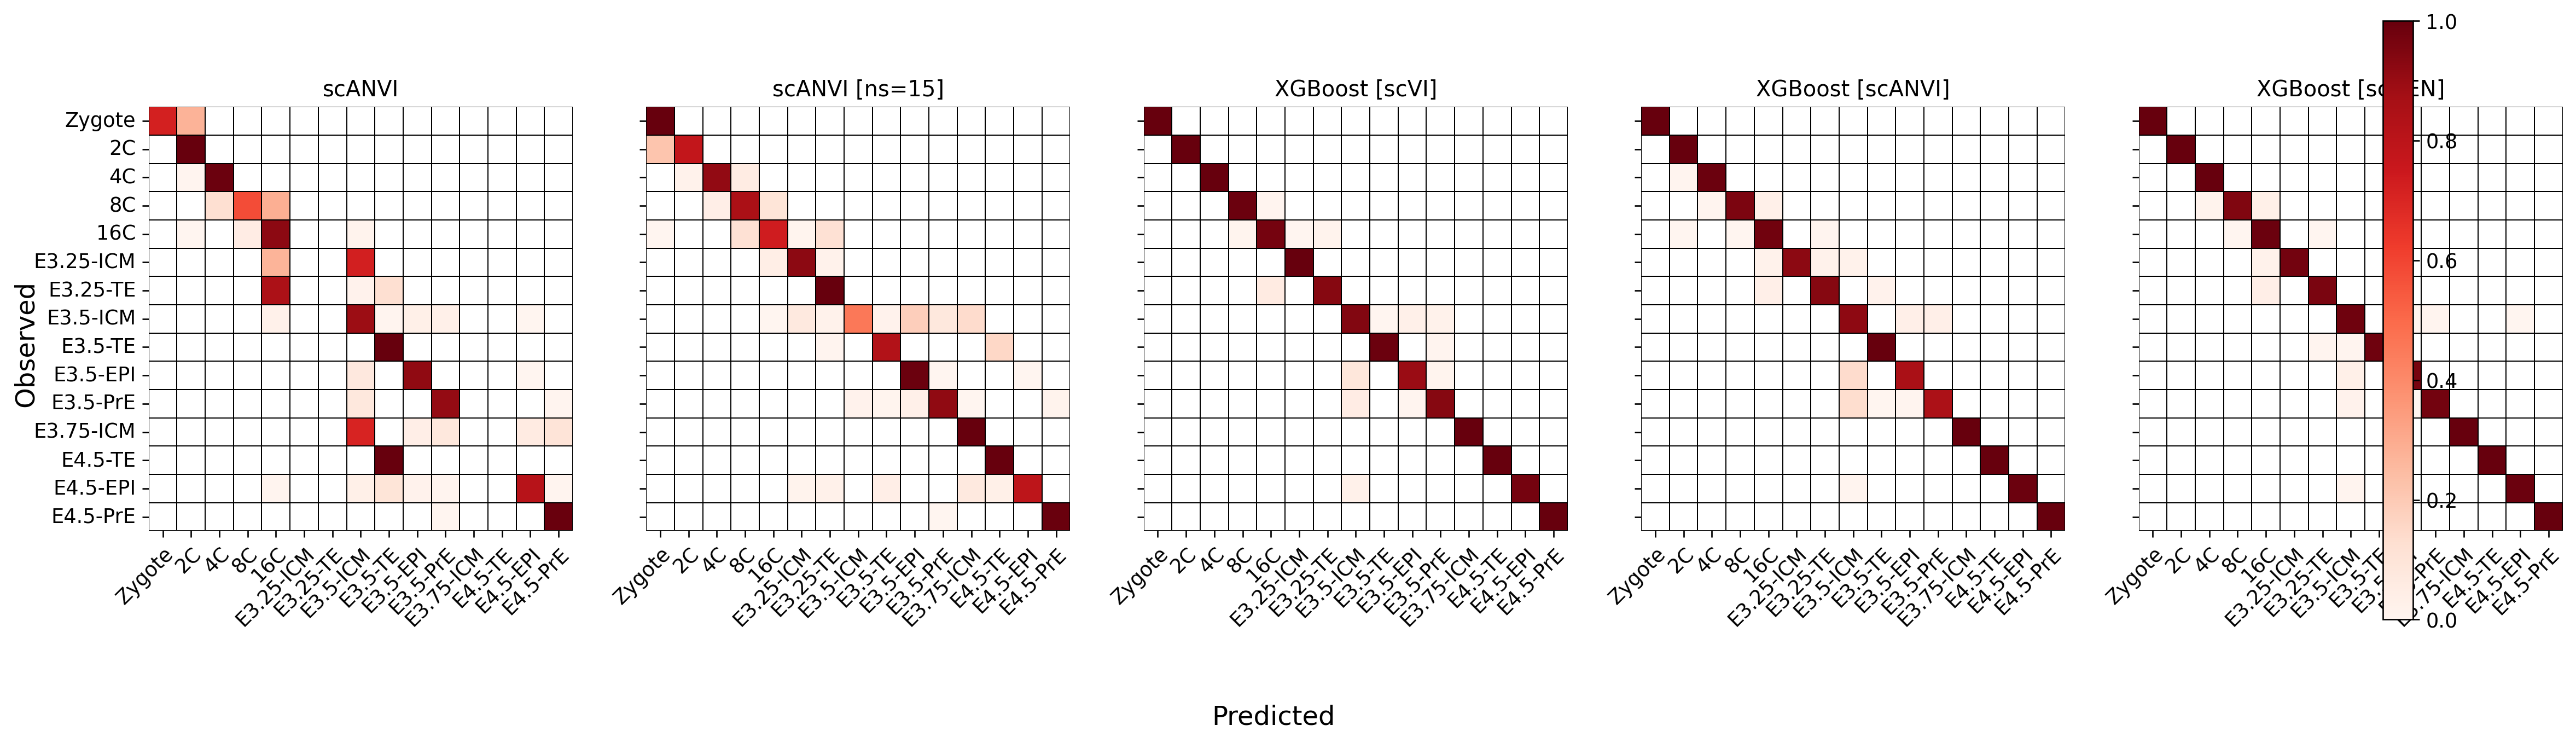

In [46]:
fig, ax = plt.subplots(1, 5, figsize=[20, 6], sharey=True, sharex=False)
for idx, clf in enumerate(mouse_accuracy.index):
    conf_df = pd.DataFrame(0, index=predictions.ct.cat.categories, columns=predictions.ct.cat.categories) + sc.metrics.confusion_matrix('ct', clf, data=predictions)
    conf_df = conf_df[predictions.ct.cat.categories]
    conf_df[conf_df == 0] = np.nan
    sns.heatmap(conf_df, linewidths=0.2, cmap='Reds', ax=ax[idx], square=True, cbar=None, linewidth=.5, linecolor='black')
    ax[idx].set_title(LABELS[idx])
    ax[idx].set_xticklabels(predictions.ct.cat.categories.tolist(), rotation=45, ha="right", rotation_mode="anchor")

fig.colorbar(cm.ScalarMappable(norm=Normalize(0,1), cmap='Reds'), ax=ax.ravel(), fraction=0.048)
fig.supxlabel('Predicted')
fig.supylabel('Observed')
fig.tight_layout()
fig.savefig("../figures/mouse/00_clf_confusion_mat.svg")

# fig, ax = plt.subplots(2, 2, figsize=[9, 9], sharey=True, sharex=True)
# for idx, clf in enumerate(['xg_scVI', 'xg_scANVI', 'xg_scGEN', 'scANVI']):
#     sns.heatmap(sc.metrics.confusion_matrix('ct', clf, data=predictions)[predictions.ct.cat.categories], 
#                 linewidths=0.2, cmap='viridis', ax=ax[idx // 2, idx % 2], square=True, cbar=None)
#     ax[idx // 2, idx % 2].set_xlabel('')
#     ax[idx // 2, idx % 2].set_ylabel('')
#     ax[idx // 2, idx % 2].set_title(f'XGBoost [{clf[3:]}]')
#     ax[idx // 2, idx % 2].set_xticklabels(predictions.ct.cat.categories.tolist(), rotation=45, ha="right", rotation_mode="anchor")
# ax[1, 1].set_title('scANVI')

# fig.colorbar(cm.ScalarMappable(norm=Normalize(0,1), cmap='viridis'), ax=ax.ravel(), fraction=0.048)
# fig.supxlabel('Predicted')
# fig.supylabel('Observed')
# fig.tight_layout()
# # fig.savefig("../figures/mouse/00_clf_confusion_mat.svg")

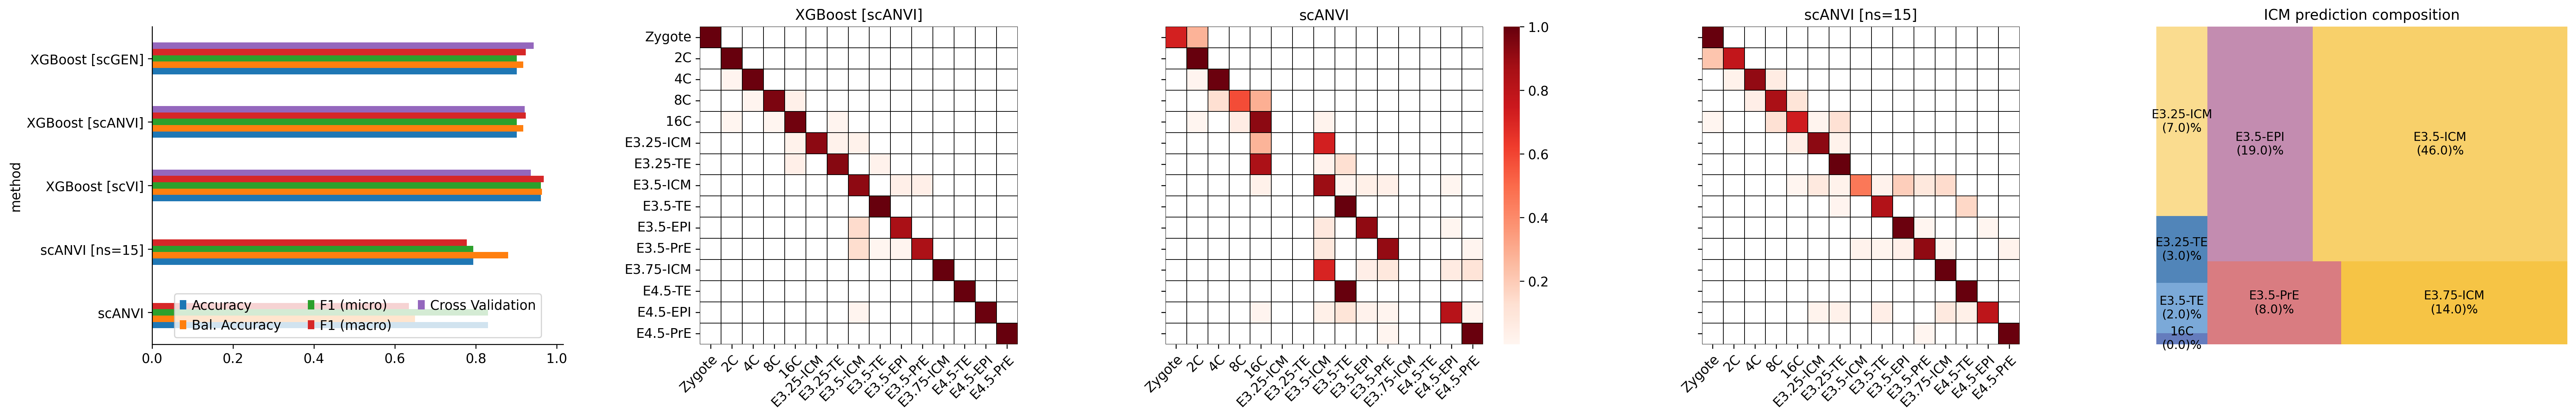

In [49]:
fig, ax = plt.subplots(1, 5, figsize=[30, 5])

mouse_accuracy_csv = pd.read_csv("../results/05_mouse_classifier_stats.csv", index_col=0)
mouse_accuracy_csv.columns = ['Accuracy', 'Bal. Accuracy', 'F1 (micro)', 'F1 (macro)', 'Cross Validation']
mouse_accuracy_csv.plot(kind='barh', ax=ax[0])
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].legend(loc='lower center', ncols=3)
ax[0].set_yticklabels(LABELS)

# XGBoost scANVI
conf_df = pd.DataFrame(0, index=predictions.ct.cat.categories, columns=predictions.ct.cat.categories) + sc.metrics.confusion_matrix('ct', 'xg_scANVI', data=predictions)
conf_df = conf_df[predictions.ct.cat.categories]
conf_df[conf_df == 0] = np.nan
sns.heatmap(conf_df, linewidths=0.2, cmap='Reds', ax=ax[1], square=True, cbar=None, linewidth=.5, linecolor='black')
ax[1].set_title(LABELS[3])
ax[1].set_xticklabels(predictions.ct.cat.categories.tolist(), rotation=45, ha="right", rotation_mode="anchor")

# scANVI
conf_df = pd.DataFrame(0, index=predictions.ct.cat.categories, columns=predictions.ct.cat.categories) + sc.metrics.confusion_matrix('ct', 'scANVI', data=predictions)
conf_df = conf_df[predictions.ct.cat.categories]
conf_df[conf_df == 0] = np.nan
sns.heatmap(conf_df, linewidths=0.2, cmap='Reds', ax=ax[2], square=True, cbar=True, linewidth=.5, linecolor='black')
ax[2].set_title(LABELS[0])
ax[2].set_xticklabels(predictions.ct.cat.categories.tolist(), rotation=45, ha="right", rotation_mode="anchor")
ax[2].set_yticklabels([' '] * predictions.ct.cat.categories.size)

# scANVI_ns15
conf_df = pd.DataFrame(0, index=predictions.ct.cat.categories, columns=predictions.ct.cat.categories) + sc.metrics.confusion_matrix('ct', 'scANVI_ns15', data=predictions)
conf_df = conf_df[predictions.ct.cat.categories]
conf_df[conf_df == 0] = np.nan
sns.heatmap(conf_df, linewidths=0.2, cmap='Reds', ax=ax[3], square=True, cbar=None, linewidth=.5, linecolor='black')
ax[3].set_title(LABELS[1])
ax[3].set_xticklabels(predictions.ct.cat.categories.tolist(), rotation=45, ha="right", rotation_mode="anchor")
ax[3].set_yticklabels([' '] * predictions.ct.cat.categories.size)

# ICM zoom
icm_accuracy = (conf_df.loc['E3.5-ICM'].dropna() * 100).sort_values(ascending=True)
squarify.plot(sizes=icm_accuracy, 
              label=icm_accuracy.index + '\n(' + icm_accuracy.round().values.astype(str) + ')%', 
              color=[ct_colors[ct] for ct in icm_accuracy.index],
              text_kwargs={'fontsize': '10'}, ax=ax[4]
             )
ax[4].axis("off")
ax[4].set_title('ICM prediction composition')
fig.tight_layout()
fig.savefig("../figures/mouse/00_clf_accuracy.svg")

In [115]:
lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi_ns_15/")

lvae.adata.obsm['x_scANVI'] = lvae.get_latent_representation()
sc.pp.neighbors(lvae.adata, use_rep='x_scANVI')
sc.tl.paga(lvae.adata, groups='ct')
sc.tl.draw_graph(lvae.adata)
lvae.adata.obs["predictions"] = lvae.predict()
lvae.adata.obs["predictions"] = lvae.adata.obs["predictions"].astype('category')
lvae.adata.obs.predictions = lvae.adata.obs.predictions.cat.reorder_categories(ct_colors.keys())
lvae.adata.obs['entropy'] = 1 - lvae.predict(soft=True).max(axis=1)

INFO     File ../results/02_mouse_integration/scanvi_ns_15/model.pt already downloaded                             


In [117]:
icm_entropy = predictions.query('ct == "E3.5-ICM"')[['scANVI_ns15']].copy()
icm_entropy['Score'] = lvae.predict(soft=True).loc[icm_entropy.index, 'E3.5-ICM']
icm_entropy.scANVI_ns15 = icm_entropy.scANVI_ns15.astype('category')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


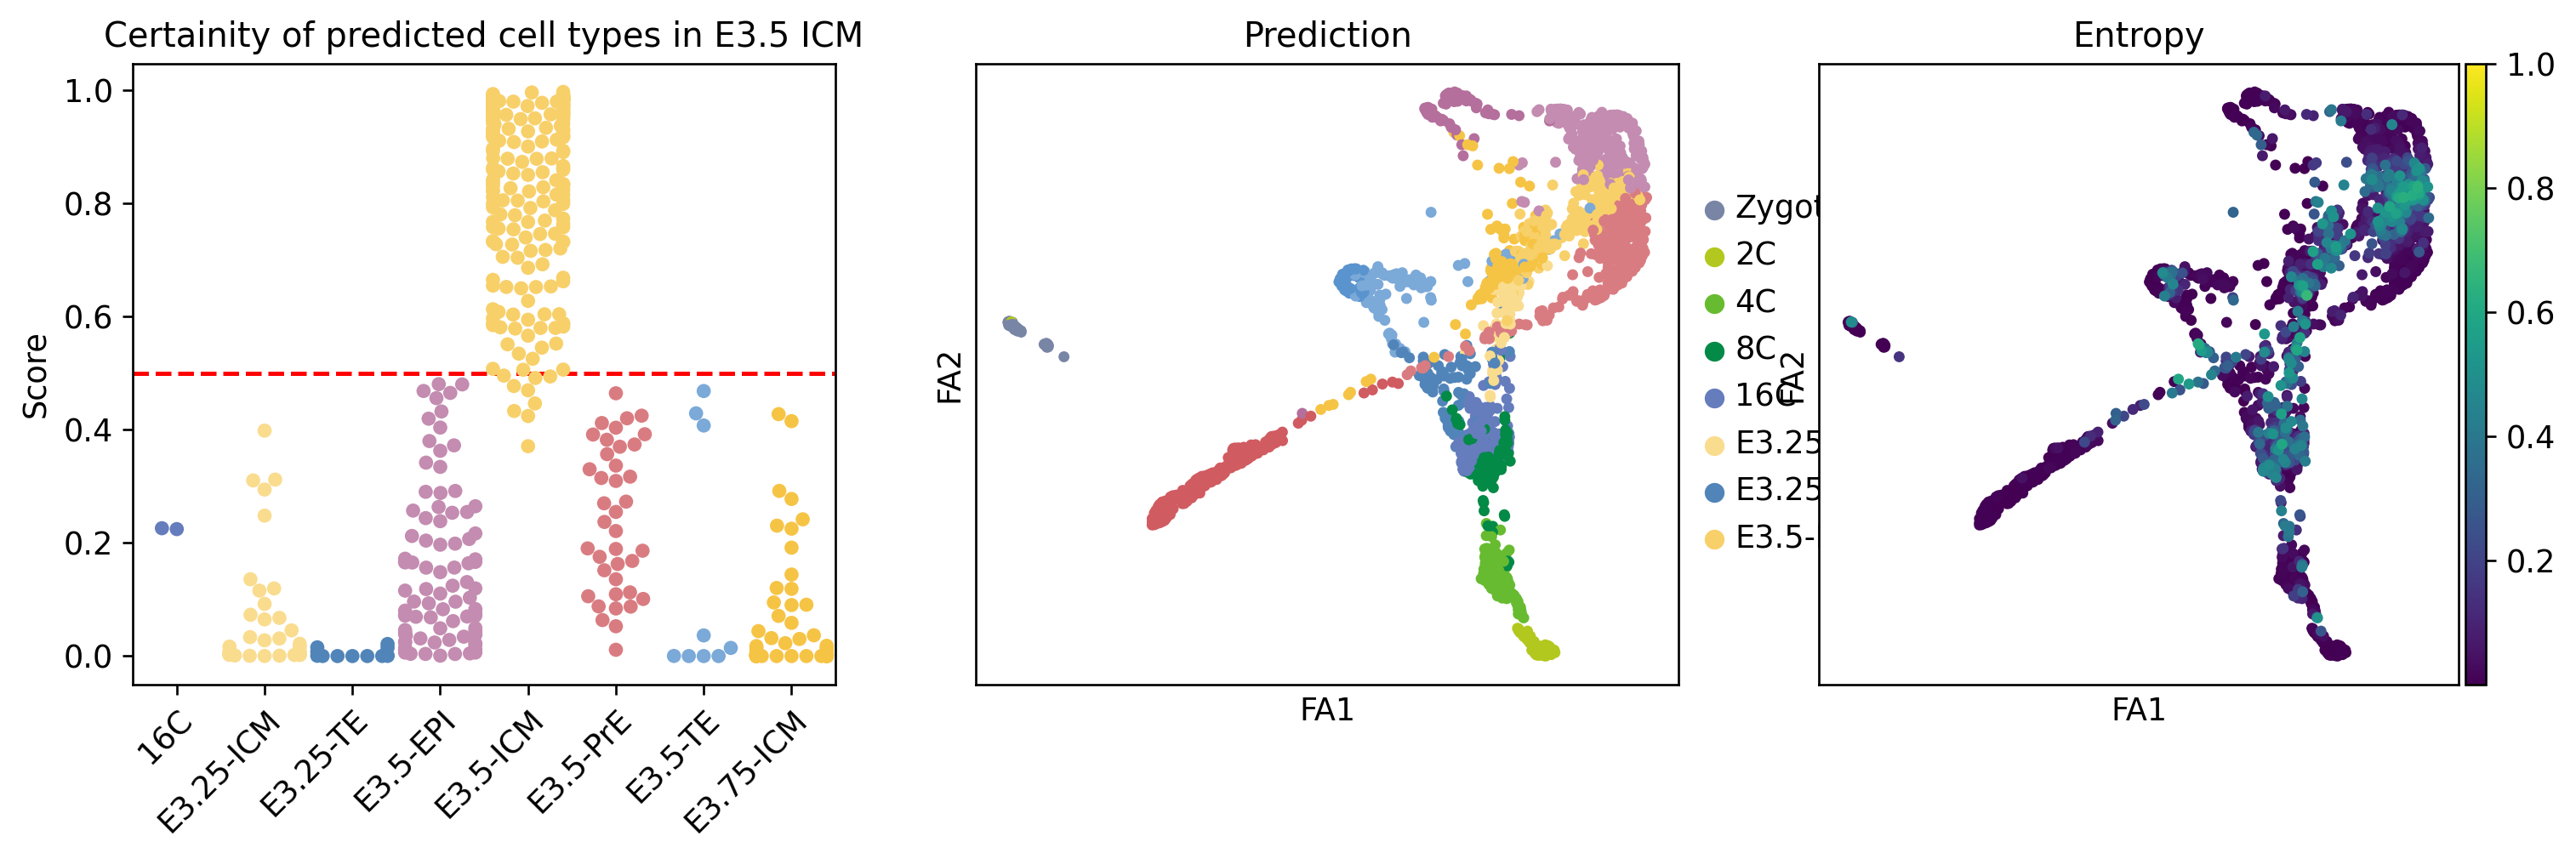

In [124]:
fig, ax = plt.subplots(1, 3, figsize=[15, 4])

sns.swarmplot(x='scANVI_ns15', y='Score', palette=[ct_colors[ct] for ct in icm_entropy.scANVI_ns15.cat.categories], data=icm_entropy, ax=ax[0])
ax[0].set_xticklabels(icm_entropy.scANVI_ns15.cat.categories, rotation=45, ha="right", rotation_mode="anchor")
ax[0].legend(frameon=False)
ax[0].axhline(y=0.5, c='r', linestyle='--')
ax[0].set_xlabel('')
ax[0].set_title('Certainity of predicted cell types in E3.5 ICM')

# plot 2, 3
lvae.adata.uns['predictions_colors'] = [ct_colors[ct] for ct in lvae.adata.obs.predictions.cat.categories]
sc.pl.draw_graph(lvae.adata, color='predictions', title='Prediction', show=False, ax=ax[1])
sc.pl.draw_graph(lvae.adata, color='entropy', vmax=1, cmap='viridis', title='Entropy', show=False, ax=ax[2])

plt.savefig("../figures/mouse/00_ICM_prediction_score.svg")

## Supl. Table 2

In [ ]:
writer = pd.ExcelWriter("../results/suppl-tab-2.xlsx", engine="xlsxwriter")

pd.read_csv("../results/05_mouse_classifier_stats.csv", index_col=0).to_excel(writer, sheet_name="mouse_overall")
for clf in mouse_accuracy.index:
    df = pd.DataFrame(0, index=predictions.ct.cat.categories, columns=predictions.ct.cat.categories) + sc.metrics.confusion_matrix('ct', clf, data=predictions)
    df = df.fillna(0)[predictions.ct.cat.categories]
    df.to_excel(writer, sheet_name=f"mouse_{clf}")
writer.close()

## Figure 3 + suppl

### Proks et al., 

In [50]:
vitro = sc.read("../results/06_proks_et_al.h5ad")
vitro.uns['predictions_colors'] = [ct_colors[x] for x in vitro.obs.predictions.cat.categories]

In [51]:
vitro.uns['FACS_colors'] = ['#ff7f0e', '#1f77b4', '#D3D3D3']

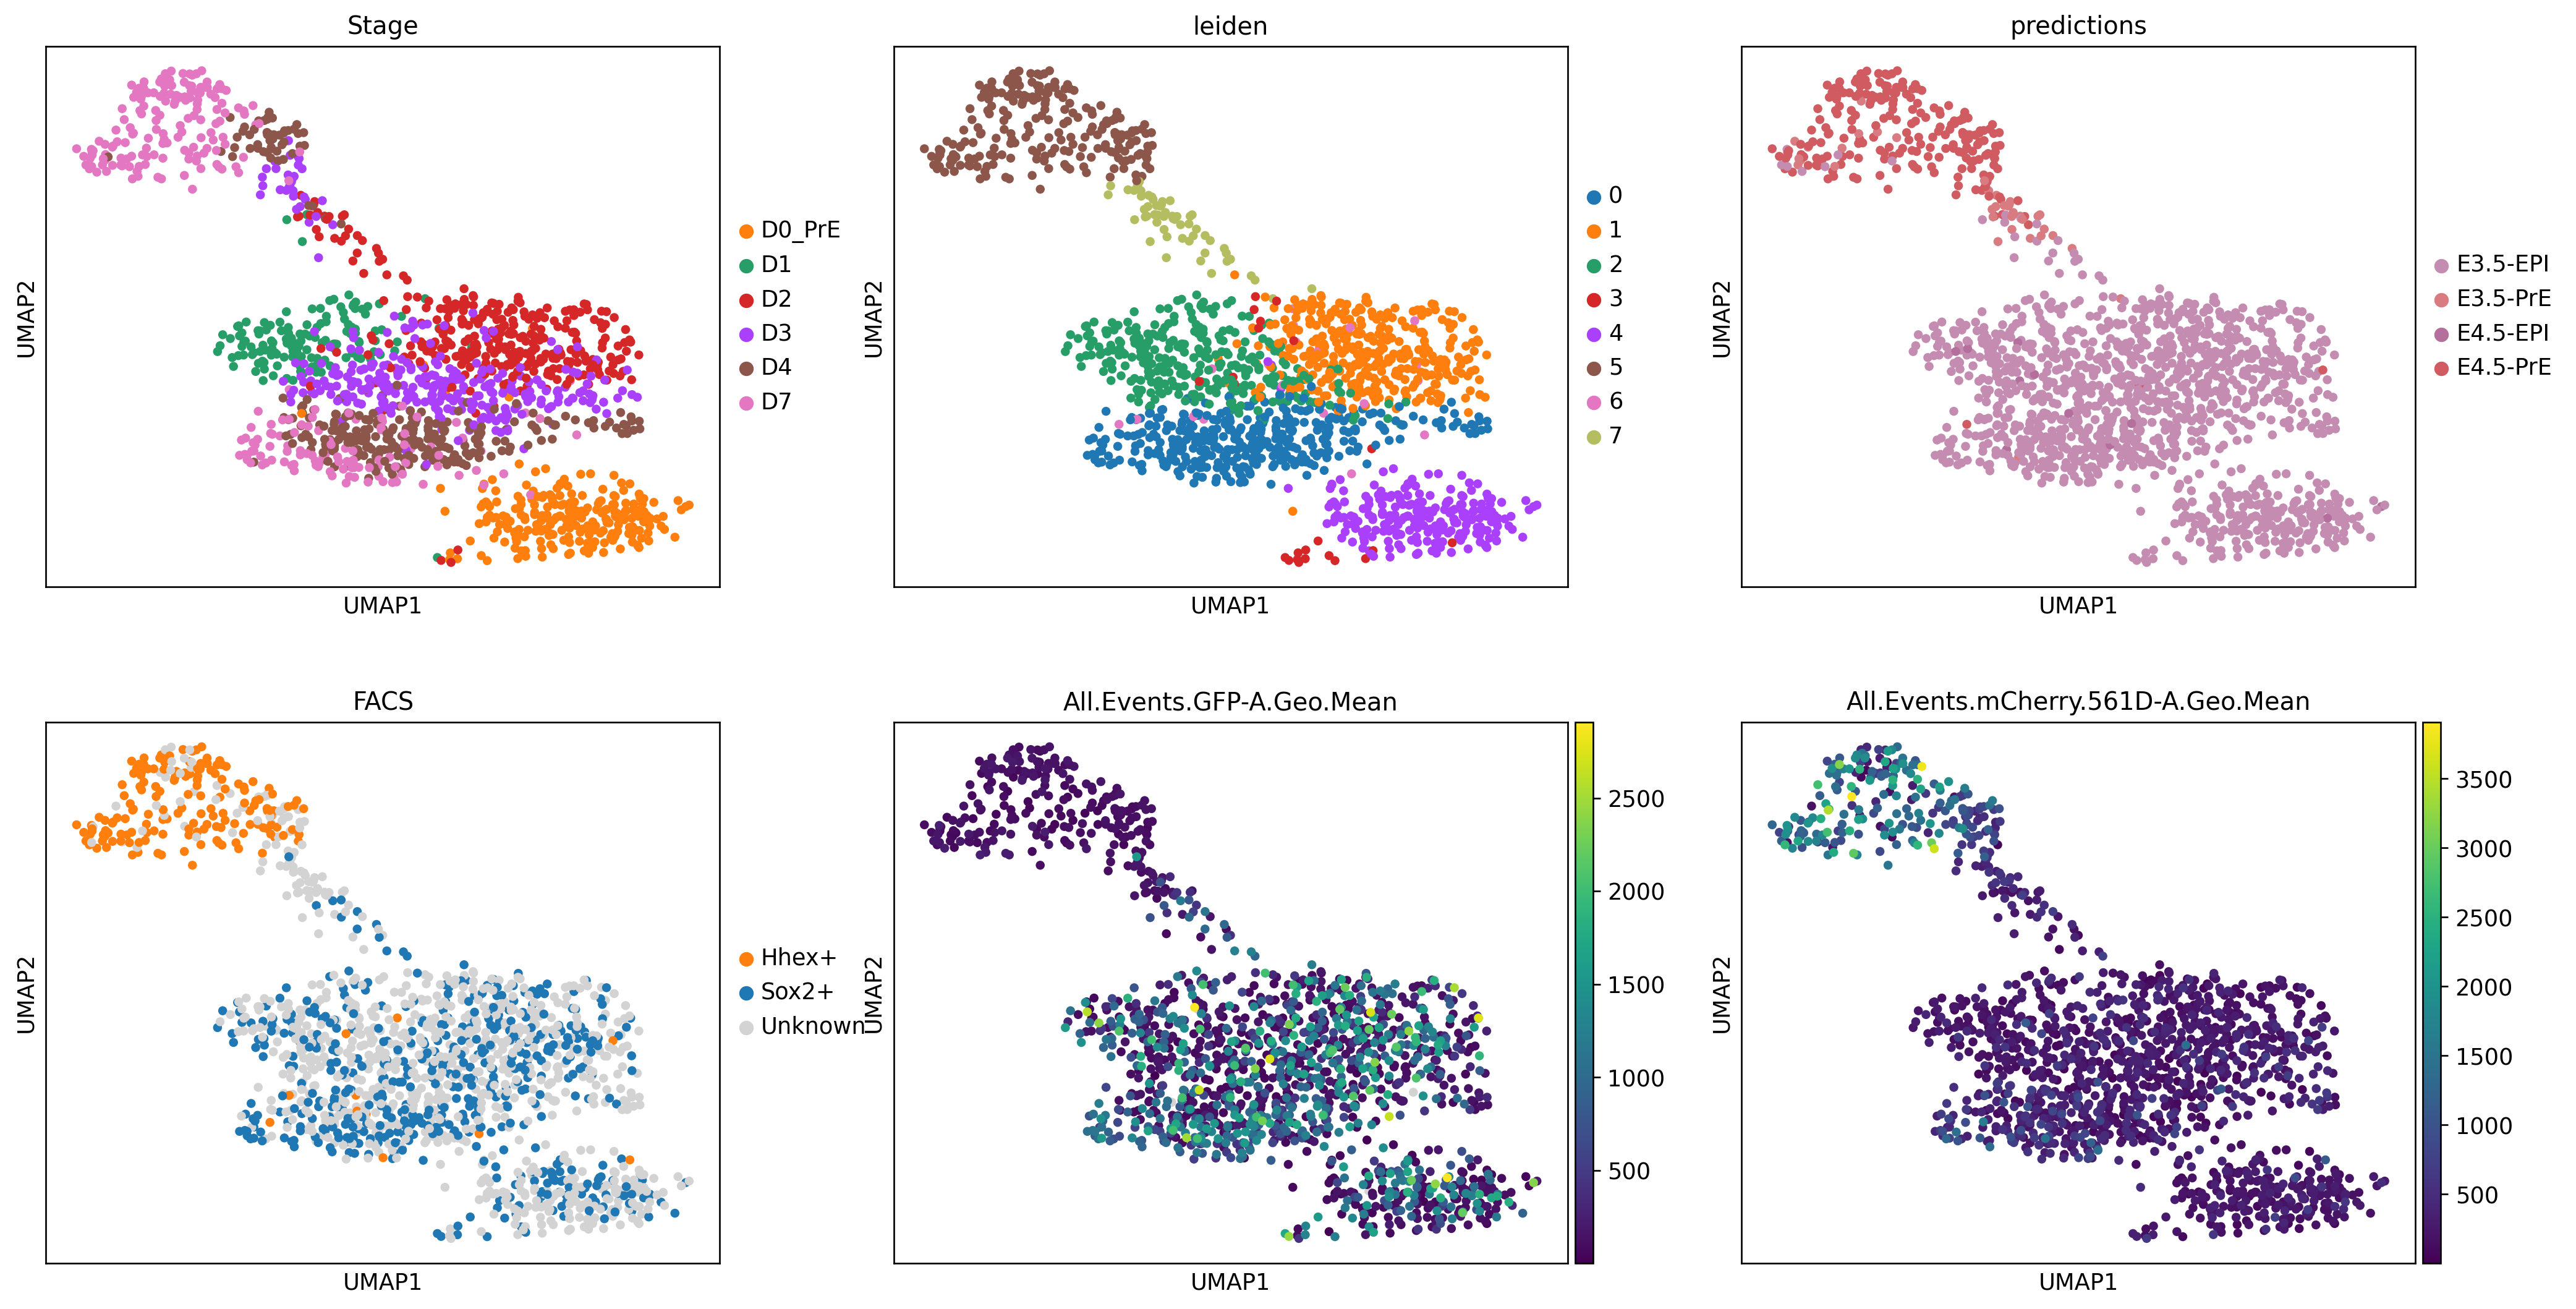

In [52]:
sc.pl.umap(vitro, ncols=3, cmap='viridis',
           color=['Stage', 'leiden', 'predictions', 'FACS', 'All.Events.GFP-A.Geo.Mean', 'All.Events.mCherry.561D-A.Geo.Mean'])

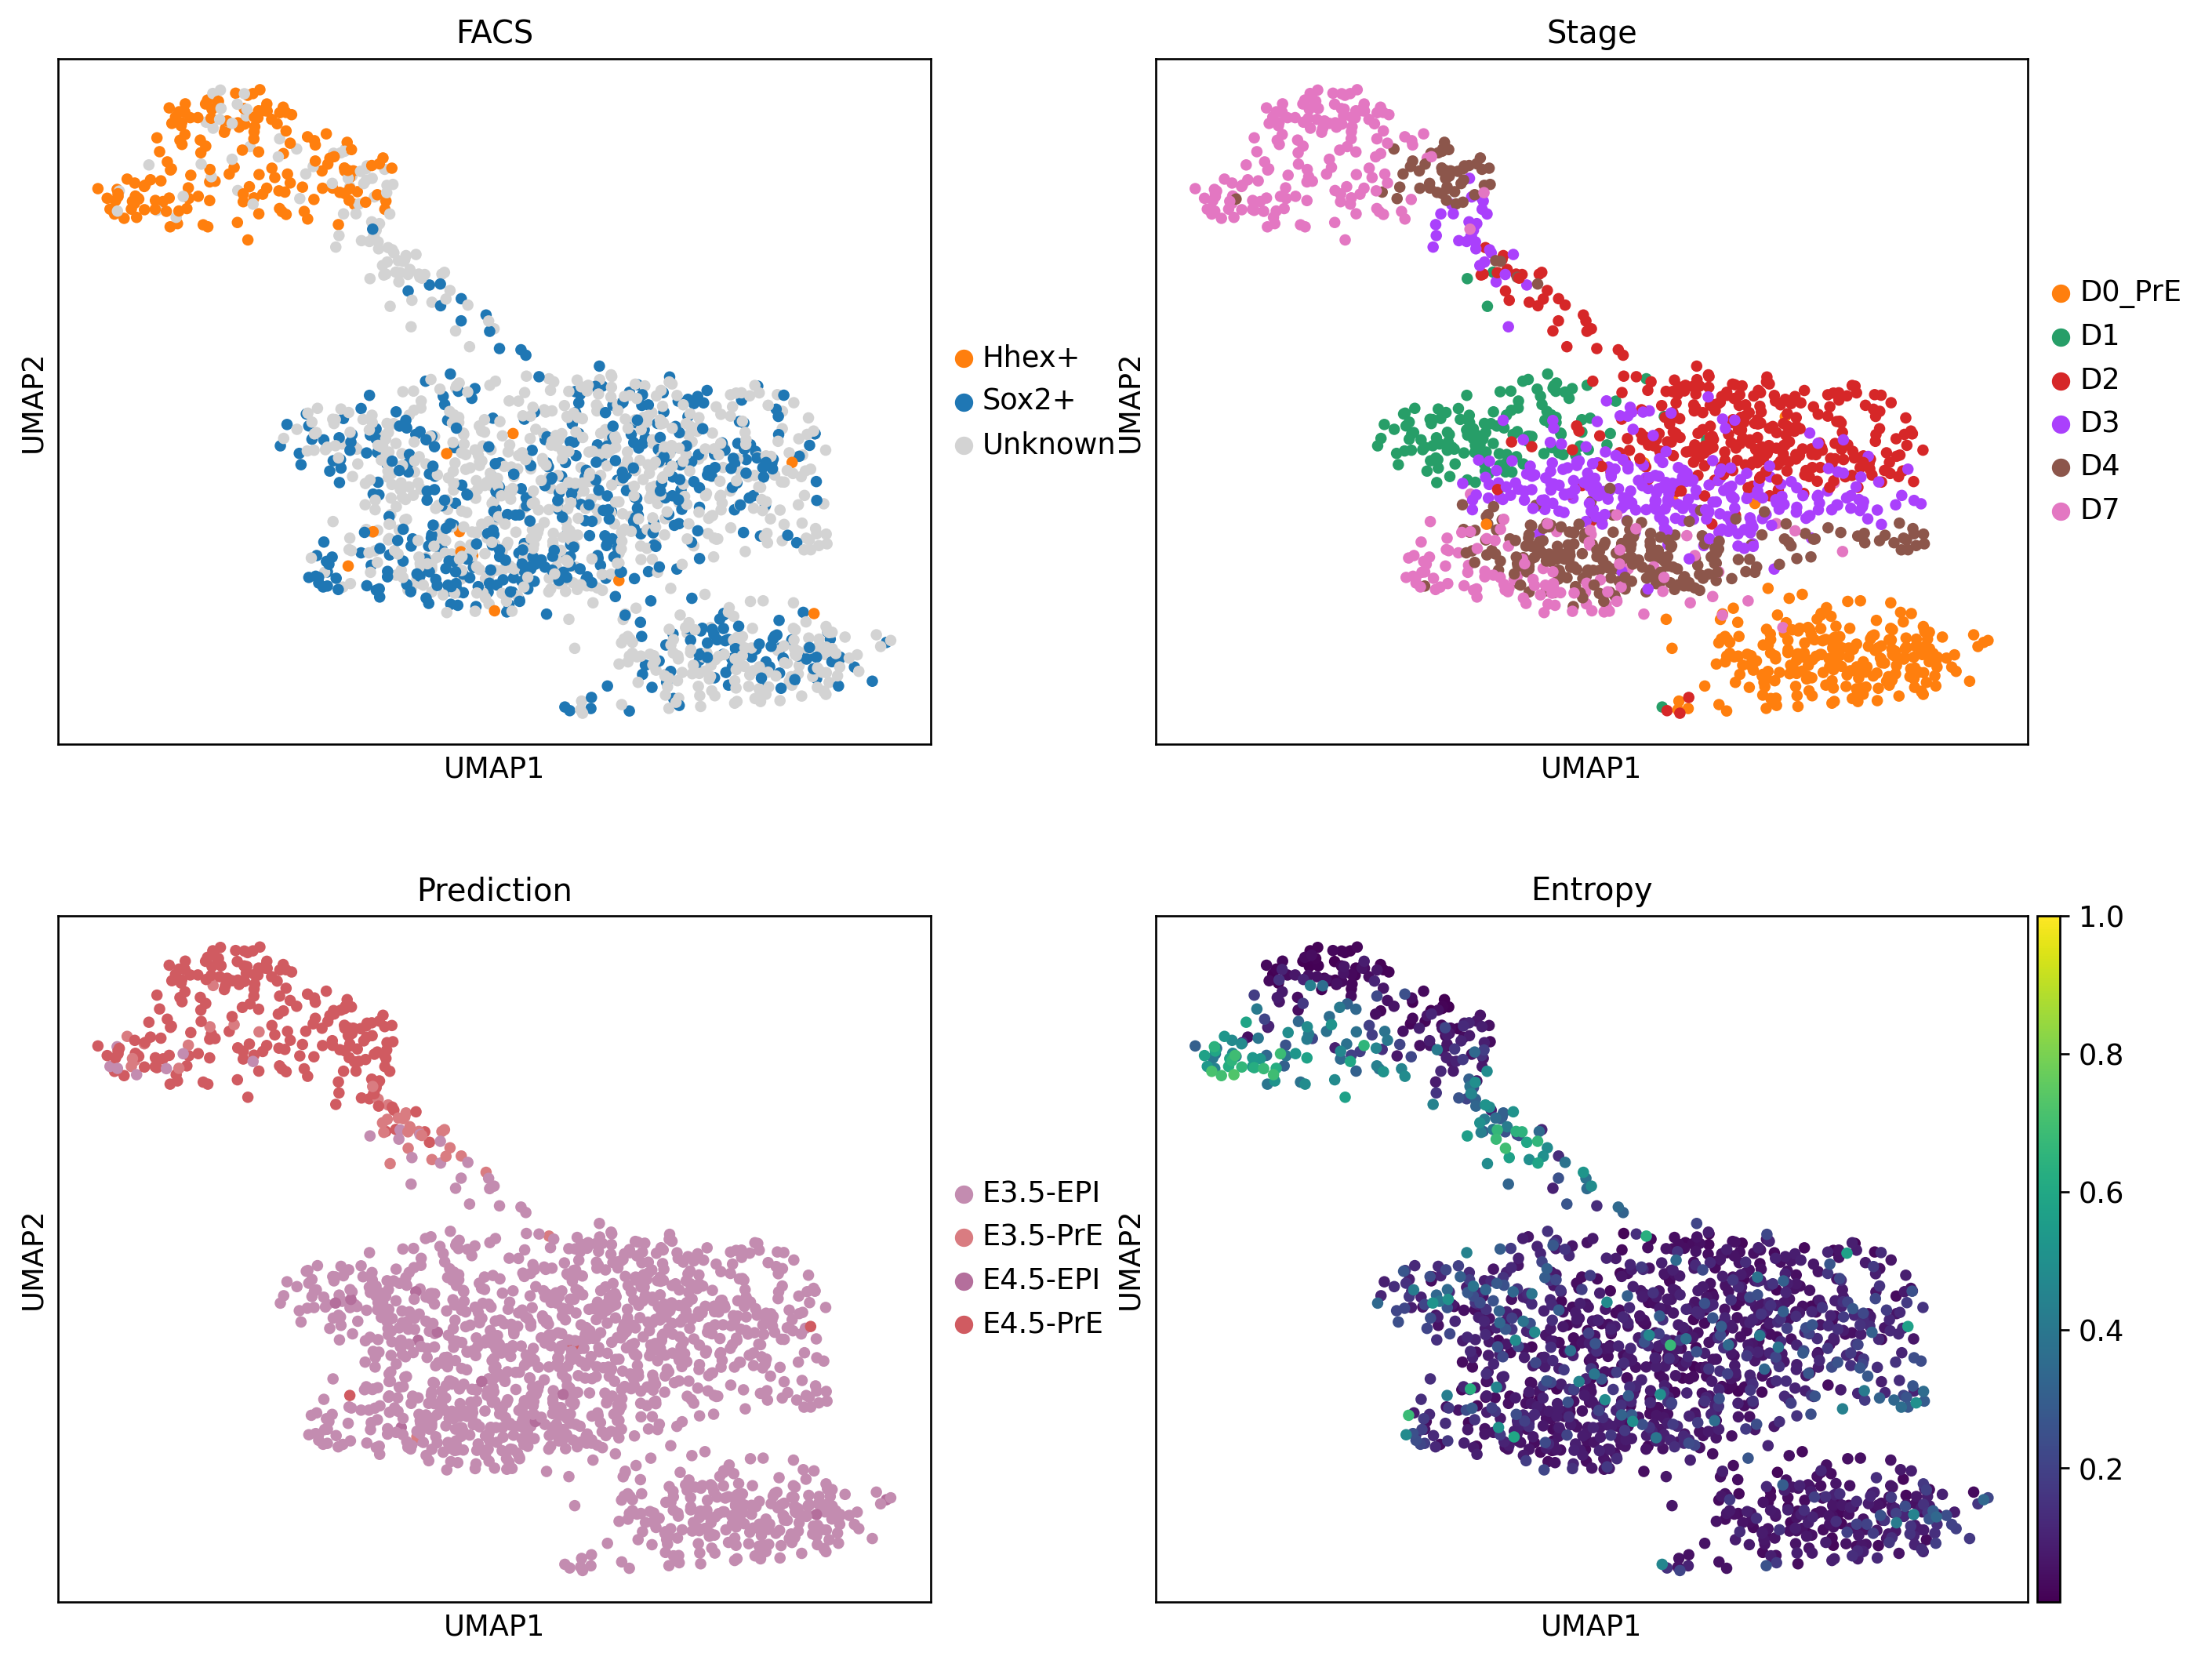

In [53]:
sc.pl.umap(vitro, color=['FACS', 'Stage', 'predictions', 'entropy'], ncols=2, vmax=1, cmap='viridis', title=['FACS', 'Stage', 'Prediction', 'Entropy'], save='00_query_proks.svg')

<Axes: xlabel='predictions', ylabel='FACS'>

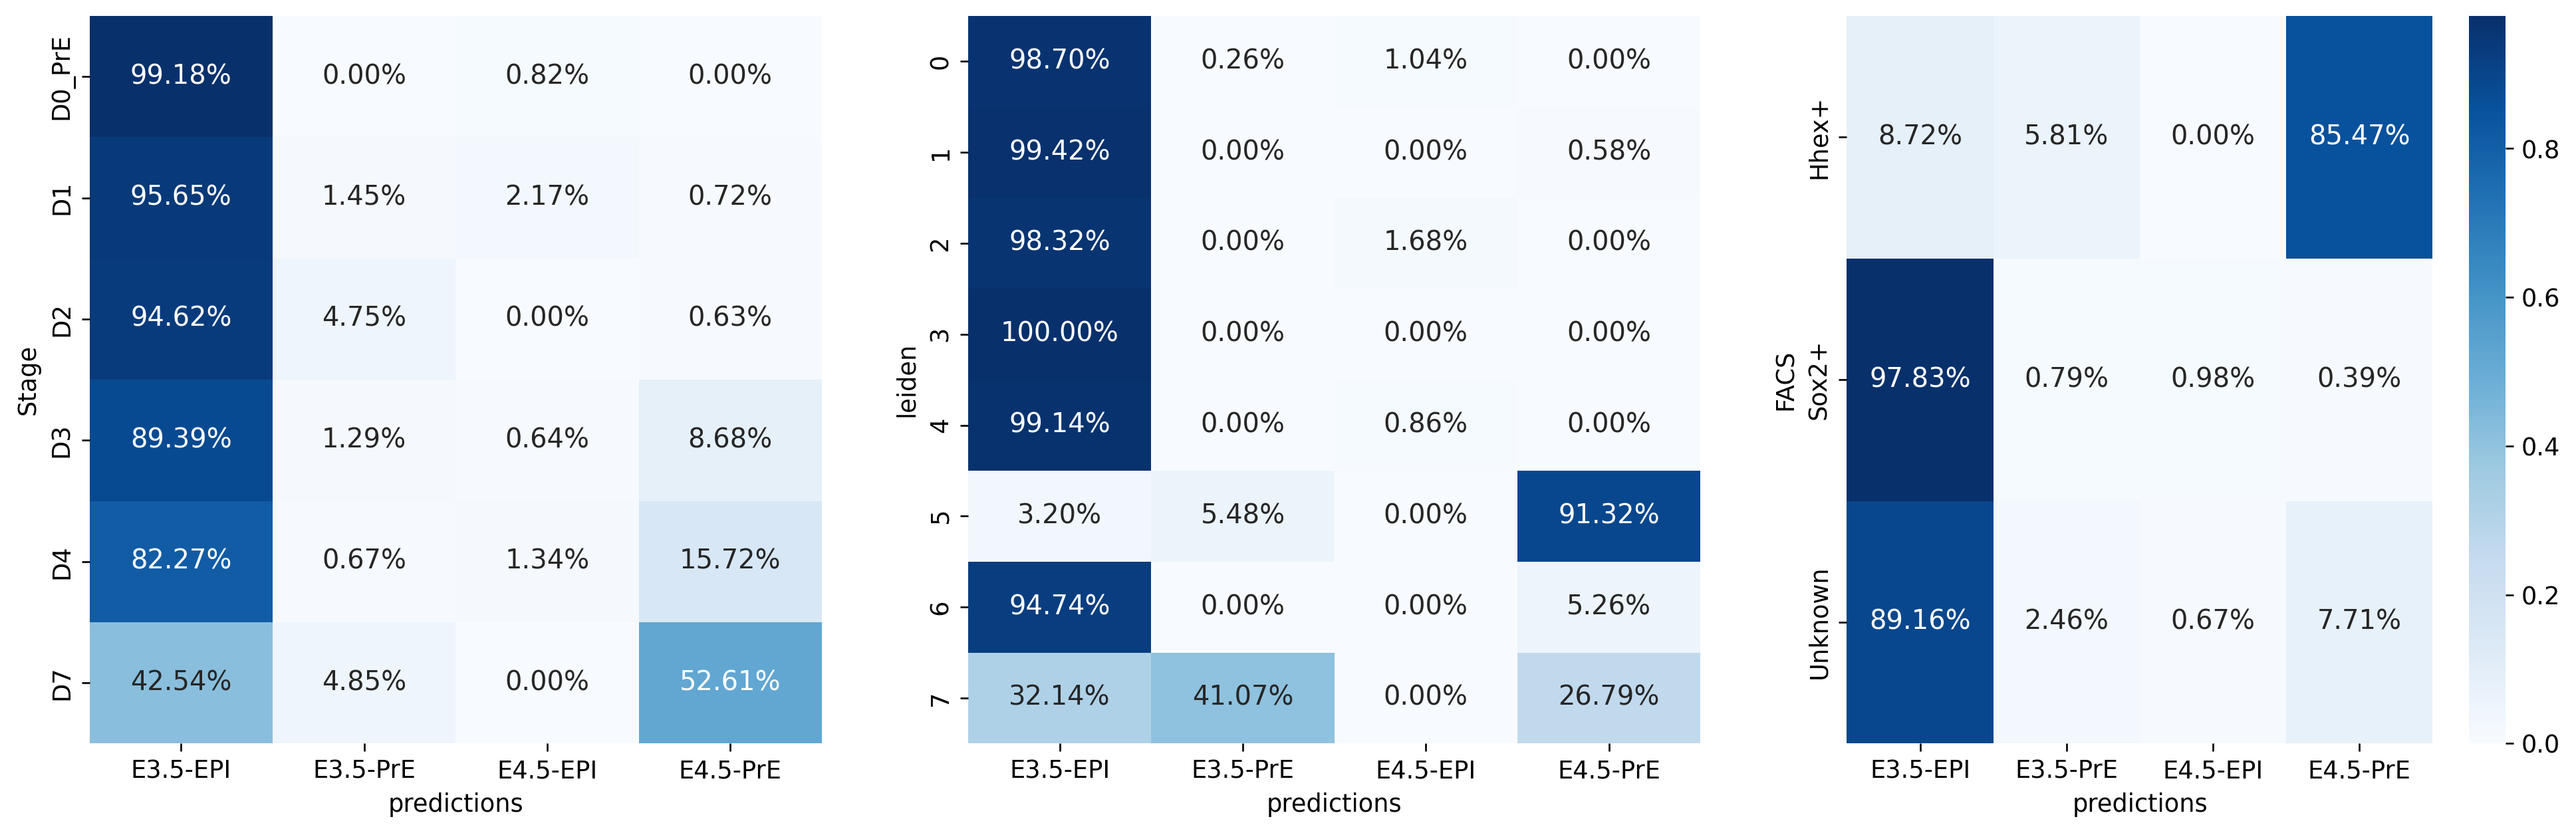

In [54]:
fig, ax = plt.subplots(1, 3, figsize=[20, 6])
sns.heatmap(sc.metrics.confusion_matrix("Stage", "predictions", vitro.obs), annot=True, fmt='.2%', cmap='Blues', ax=ax[0], cbar=False)
sns.heatmap(sc.metrics.confusion_matrix("leiden", "predictions", vitro.obs), annot=True, fmt='.2%', cmap='Blues', ax=ax[1], cbar=False)
sns.heatmap(sc.metrics.confusion_matrix("FACS", "predictions", vitro.obs), annot=True, fmt='.2%', cmap='Blues', ax=ax[2])

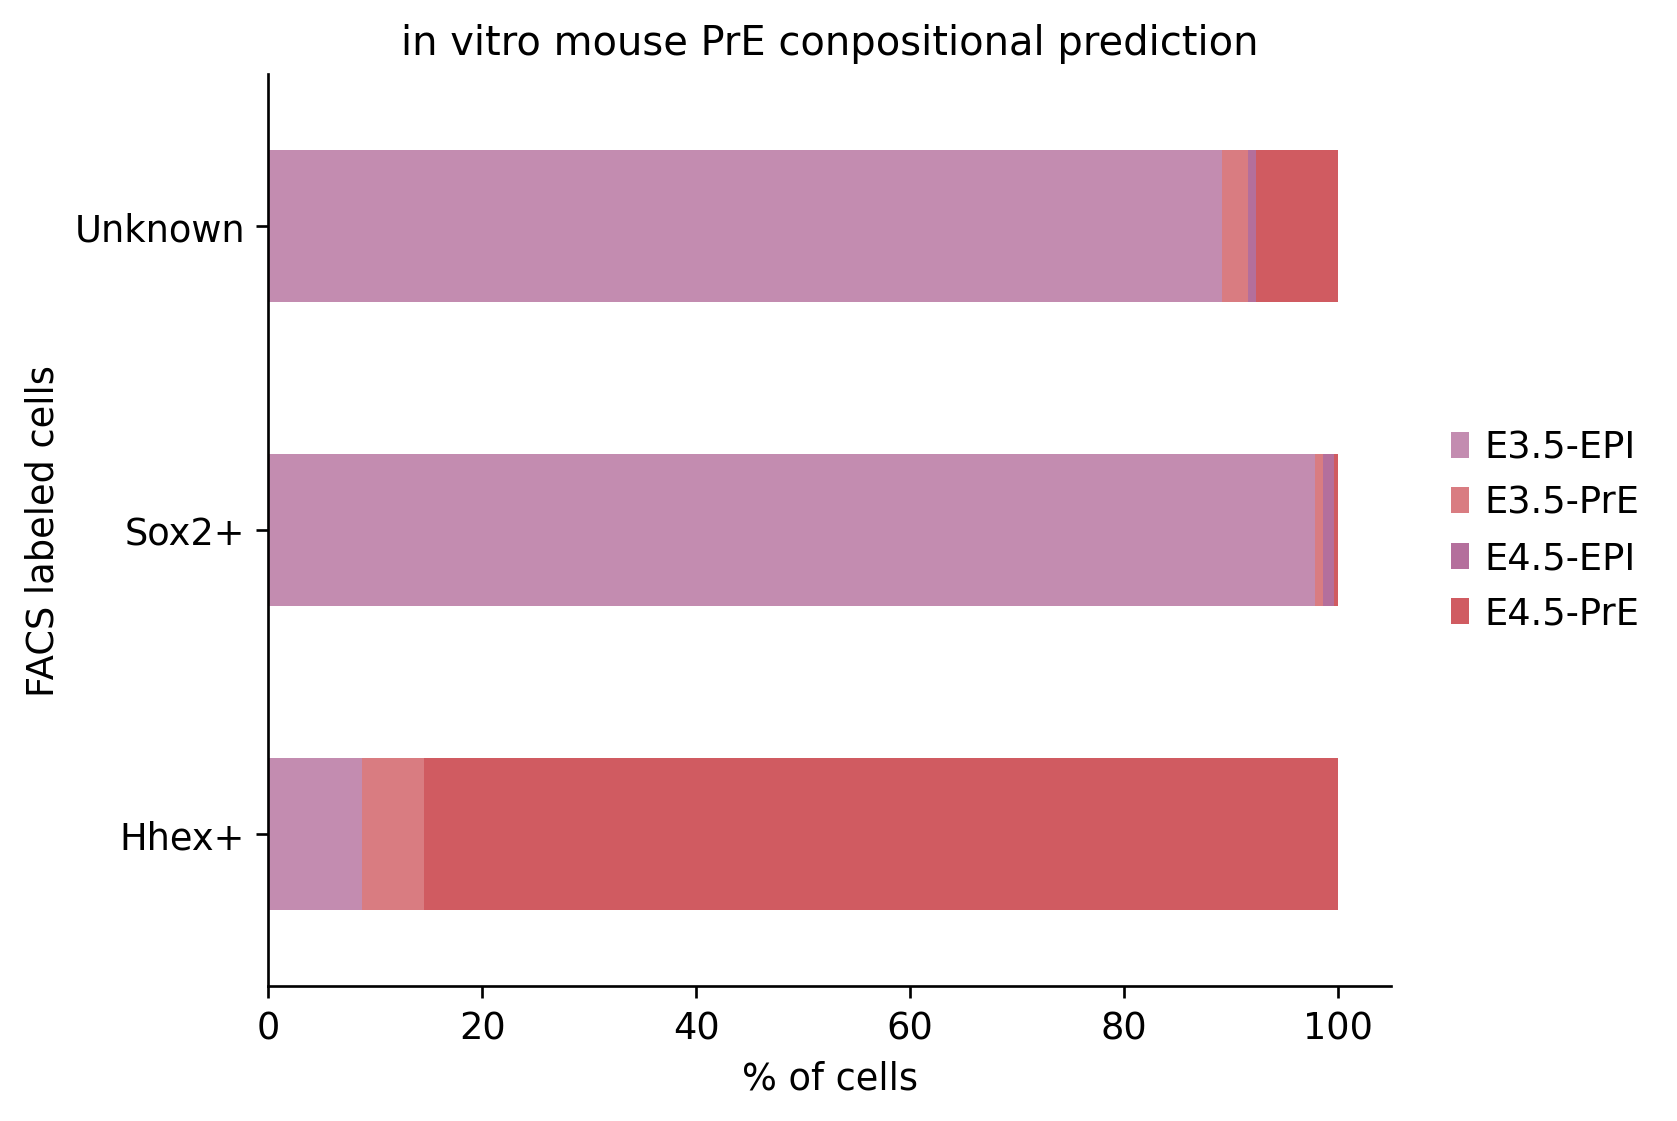

In [56]:
conf_mat = (sc.metrics.confusion_matrix('FACS', 'predictions', vitro.obs) * 100)
conf_mat.plot.barh(stacked=True, color=ct_colors)
plt.legend(conf_mat.columns.str.replace('_', ' '), loc='center right', bbox_to_anchor=(1.25, 0.5), frameon=False)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xlabel('% of cells')
plt.ylabel('FACS labeled cells')
plt.title('in vitro mouse PrE conpositional prediction')

plt.savefig("../figures/mouse/00_query_facs_predictions.svg")
sc.metrics.confusion_matrix('FACS', 'predictions', vitro.obs, normalize=False).to_csv("../results/00_mouse_query.csv")